In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
data = pd.read_csv('/content/customer_churn.csv')

# Drop irrelevant columns like 'Names' and 'Company'
data = data.drop(['Names', 'Company'], axis=1)

# Define features (X) and target (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numerical_columns = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']  # numerical columns
categorical_columns = ['Account_Manager', 'Location']  # categorical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert sparse matrices to dense arrays
X_train = X_train.toarray()
X_test = X_test.toarray()

### Model 1: Restricted Boltzmann Machine (RBM) with Logistic Regression

# Define and train RBM
rbm = BernoulliRBM(n_components=64, random_state=42)
rbm.fit(X_train)
X_train_rbm = rbm.transform(X_train)
X_test_rbm = rbm.transform(X_test)

# Train Logistic Regression with RBM features
classifier = LogisticRegression()
classifier.fit(X_train_rbm, y_train)
y_pred = classifier.predict(X_test_rbm)
print(f'Accuracy of RBM + Logistic Regression: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))


### Model 2: Generative Adversarial Network (GAN)

# Define the generator model
def build_generator(latent_dim, n_features):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_features, activation='sigmoid')
    ])
    return model

# Define the discriminator model
def build_discriminator(n_features):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=n_features),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_gan(generator, discriminator):
    model = keras.Sequential([generator, discriminator])
    return model

latent_dim = 100
n_features = X_train.shape[1]
generator = build_generator(latent_dim, n_features)
discriminator = build_discriminator(n_features)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gan = build_gan(generator, discriminator)
discriminator.trainable = False
gan.compile(optimizer='adam', loss='binary_crossentropy')

# GAN Training
def train_gan(gan, generator, discriminator, X_train, epochs, batch_size):
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        generated_data = generator.predict(noise)
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        valid_labels = np.ones((batch_size, 1))
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}')

# Train the GAN
epochs = 100
batch_size = 32
train_gan(gan, generator, discriminator, X_train, epochs, batch_size)


Accuracy of RBM + Logistic Regression: 0.85
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       148
           1       0.86      0.19      0.31        32

    accuracy                           0.85       180
   macro avg       0.85      0.59      0.61       180
weighted avg       0.85      0.85      0.81       180



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Epoch: 0, D Loss: 0.6851962804794312, G Loss: [array(0.64995784, dtype=float32), array(0.64995784, dtype=float32), array(0.53125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [7]:
# Generate synthetic samples
num_samples = 5  # Number of samples to generate
latent_dim = 100  # Make sure this matches the latent_dim defined in the GAN

# Generate random noise as input to the generator
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_data = generator.predict(noise)

print("Generated Synthetic Data Samples:\n", synthetic_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
Generated Synthetic Data Samples:
 [[5.7309167e-05 4.7788075e-05 8.4483399e-05 ... 5.5162754e-04
  1.2028756e-05 1.4681689e-04]
 [2.4042821e-04 1.3167685e-04 3.3016465e-04 ... 1.6092407e-03
  6.9904359e-05 7.0030155e-04]
 [5.0191997e-05 5.3974323e-05 1.7073596e-04 ... 8.5996522e-04
  7.2855532e-06 2.7802354e-04]
 [8.6773602e-05 3.6676003e-05 7.7165823e-05 ... 3.4503441e-04
  1.5892409e-05 4.2149107e-04]
 [7.2781288e-05 4.7220095e-05 8.4576182e-05 ... 5.2103627e-04
  1.3124417e-05 2.9026155e-04]]


In [10]:
# Print raw predictions on test data
y_pred = classifier.predict(X_test_rbm)
print("Predictions on Test Data:\n", y_pred)
print("True Labels:\n", y_test.values)


Predictions on Test Data:
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
True Labels:
 [1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1]


PREDICTIONS

In [9]:
# Example of a new sample for prediction
import pandas as pd

# Replace with actual values based on your feature names
new_data = pd.DataFrame({
    'Age': [35],
    'Total_Purchase': [12000],
    'Account_Manager': [1],  # 1 for 'yes', 0 for 'no'
    'Years': [5],
    'Num_Sites': [8],
    'Location': ['Location_A']  # Example location
})

# Step 1: Preprocess the new data
new_data_processed = preprocessor.transform(new_data)
new_data_processed = new_data_processed.toarray()  # Convert to dense format if needed

# Step 2: Transform with RBM
new_data_rbm = rbm.transform(new_data_processed)

# Step 3: Predict churn outcome with Logistic Regression
new_prediction = classifier.predict(new_data_rbm)
print("Churn Prediction (0 = No, 1 = Yes):", new_prediction[0])

# Step 4: Get Prediction Probabilities (Optional)
prediction_proba = classifier.predict_proba(new_data_rbm)
print("Probability of No Churn:", prediction_proba[0][0])
print("Probability of Churn:", prediction_proba[0][1])


Churn Prediction (0 = No, 1 = Yes): 0
Probability of No Churn: 0.9063975202342871
Probability of Churn: 0.09360247976571284


Confusion Matrix

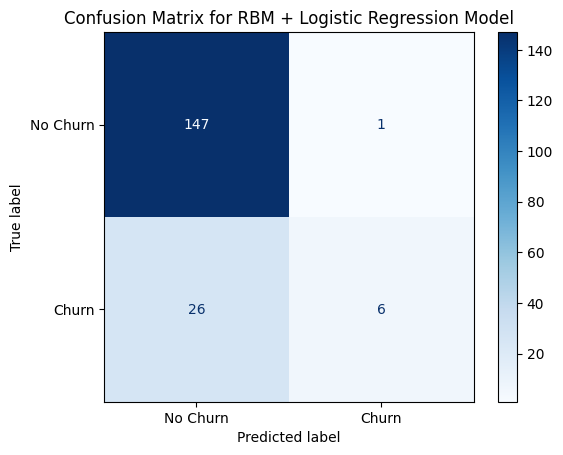

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions on the test set
y_pred = classifier.predict(X_test_rbm)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for RBM + Logistic Regression Model")
plt.show()
